In [220]:
import pandas as pd
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer, AutoTokenizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [221]:
class ProteinLM(nn.Module):
    def __init__(self, model_name="Rostlab/prot_bert"):
        super(ProteinLM, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = output.last_hidden_state
        return embeddings

In [222]:
def t_sne(embeddings):
    X = embeddings.mean(dim=1).cpu().detach().numpy()
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=3000).fit_transform(X)
    return tsne

In [223]:
def tokenize_kmers(sequence, k=3):
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

In [224]:
def esm_tokenizer(sequences, max_length=358):
    tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
    tokenized = tokenizer(
        sequences,
        return_tensors="pt",
        padding='max_length',
        truncation=True,
        max_length=max_length
    )
    return tokenized['input_ids'], tokenized['attention_mask']

In [225]:
data = pd.read_csv("data.csv")
sequences = data["input"].apply(lambda seq: " ".join(seq)).tolist()

In [226]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ProteinLM().to(device)

tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert")
encoding = tokenizer(sequences, padding=True, truncation=True, return_tensors="pt", max_length=358)

In [ ]:
input_ids, attention_mask = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)

model.eval()
with torch.no_grad():
    embeddings = model(input_ids=input_ids, attention_mask=attention_mask)

In [177]:
tsne = t_sne(embeddings)

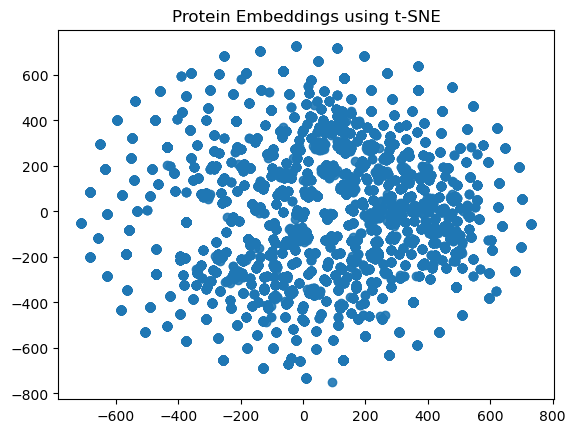

<Figure size 640x480 with 0 Axes>

In [181]:
plt.scatter(tsne[:, 0], tsne[:, 1], alpha=0.9)
plt.title("Protein Embeddings using t-SNE")
plt.xlabel("")
plt.ylabel("")
plt.show()

In [182]:
data = pd.read_csv("data.csv")
data["input"] = embeddings.detach().cpu().numpy().tolist()
data.to_csv("data.csv", index=False)